# PELIC data

Elena Cimino
e.cimino@pitt.edu

## Goal
The goal for this notebook is to explore the files in PELIC, and to also trim it down to only what we need. There's a lot of first languages in this corpus, but I'm only interested in three: Arabic, Korean, and Spanish.

### Table of Contents:
1. [Setup](#setup): setting up the notebook, reading in files, loading libraries
2. [Trimming](#trim): extracting only what we care about
3. [Modification](#modify): doing some processing, similar to what was done in balc_clean (TTR, Guiraud's R, etc.)
4. [Descriptive](#describe): doing some descriptive and visual digging into the data
5. [Lemma](#lemma): Looking at the lemmas for Arabic, Korean, and Spanish L1s (in level 3)
6. [Conclusion](#conclusion): wrapping up what was found out in this notebook

<a id='setup'></a>
## Setup
Importing libraries, reading files in, the usual.

In [14]:
import pandas as pd
import numpy as np
import pickle
import re 

import math

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%pprint            # to turn off pretty printing

Pretty printing has been turned OFF


In [3]:
# open pickled out data from PELIC
f = open('/Users/elenacimino/Data-Archive/combo_df_1A_pt1.pkl', 'rb')
data = pickle.load(f)
f.close()

data.head()

,question_id,anon_id,user_file_id,text,class_code,level_id,native_language,version,toks_re,toks_re_len,toks_nltk
answer_id,,,,,,,,,,,
1,5,eq0,7505,I met my friend Nife while I was studying in a...,g,4,Arabic,1,"[i, met, my, friend, nife, while, i, was, stud...",177,"[I, met, my, friend, Nife, while, I, was, stud..."
2,5,am8,7506,"Ten years ago, I met a women on the train betw...",g,4,Thai,1,"[ten, years, ago, i, met, a, women, on, the, t...",137,"[Ten, years, ago, ,, I, met, a, women, on, the..."
3,12,dk5,7507,In my country we usually don't use tea bags. F...,w,4,Turkish,1,"[in, my, country, we, usually, don, t, use, te...",63,"[In, my, country, we, usually, do, n't, use, t..."
4,13,dk5,7507,I organized the instructions by time.,w,4,Turkish,1,"[i, organized, the, instructions, by, time]",6,"[I, organized, the, instructions, by, time, .]"
5,12,ad1,7508,"First, prepare a port, loose tea, and cup.\nSe...",w,4,Korean,1,"[first, prepare, a, port, loose, tea, and, cup...",59,"[First, ,, prepare, a, port, ,, loose, tea, ,,..."


<a id='trim'></a>
## Downsizing
Let's cut down to only what we need. But first, let's take a look at what we have.

In [4]:
data.describe()

,question_id,user_file_id,level_id,version,toks_re_len
count,46239.000000,46239.000000,46239.000000,46239.000000,46239.000000
mean,3184.655442,55034.357469,4.030970,1.117887,91.249811
std,1756.328070,26230.780188,0.858087,0.438146,155.623180
min,1.000000,7505.000000,2.000000,1.000000,0.000000
25%,1774.000000,31263.000000,3.000000,1.000000,9.000000
50%,3161.000000,57949.000000,4.000000,1.000000,23.000000
75%,4732.000000,77101.500000,5.000000,1.000000,114.000000
max,6139.000000,100918.000000,5.000000,21.000000,2432.000000


In [5]:
# breakdown of data by native language (L1) and level 
data.groupby('native_language')['level_id'].value_counts()

native_language  level_id
                 3           3572
                 4           3200
                 5           2048
                 2            123
Arabic           4           4376
                 5           3732
                 3           3606
                 2            771
Chinese          5           3241
                 4           2360
                 3           1246
                 2            108
English          3             74
                 2             52
                 4             16
                 5             12
Farsi            4             43
                 3             26
                 5             10
French           5            194
                 4            169
                 3             68
German           3             25
                 5             23
                 4             11
Hebrew           5             62
                 4             13
                 3              3
Italian          5    

I'm only interested in three languages, so I'll only target those 3. Additionally, there's some other cutting down that I need to do. I want to make sure that: 
- All texts pulled are the first version, so they're not revised essays
- All speakers are at least a level 3 (no Level 2 Spanish makes it passed the other filters)
- All texts are at least 10 tokens long 
- The texts are sourced from writing ('w') class (there is also grammar, speaking, listening, and reading classes)

In [6]:
target_langs = ['Arabic', 'Korean', 'Spanish']
filters = (data.native_language.isin(target_langs)) & \
          (data.version == 1) & (data.level_id >= 3) & \
          (data.toks_re_len >= 10) & (data.class_code == 'w')

In [7]:
# looking at what we have
data[filters].groupby('native_language')['level_id'].value_counts()

native_language  level_id
Arabic           4           1218
                 5           1006
                 3            593
Korean           4            827
                 5            620
                 3            298
Spanish          4            155
                 5             91
                 3             64
Name: level_id, dtype: int64

In [8]:
target_data = data[filters]

<a id='modify'></a>
## Modifying 
Here, I'll copy some of the things I did to the cepa files in [BALC_clean.ipynb](https://nbviewer.jupyter.org/github/Data-Science-for-Linguists-2019/ESL-Article-Acquisition/blob/master/exploratory-analysis/BALC_clean.ipynb#expand), such as getting TTR and Guiraud's R.

In [9]:
# taken from the balc_clean notebook
def get_TTR(toks):
    """All tokens are lowercased, punctuation is included.
    Get TTR by dividing set of lowercased tokens by length of tokens."""
    all_toks = [x.lower() for x in toks]
    if len(all_toks) == 0:  
        return 0
    else: return len(set(all_toks))/len(all_toks)

def get_GUI(toks):
    """All tokens are lowercased, punctuation is included.
    Get Guiraud's R measure of lexical complexity by dividing set of lowercased tokens by the square root of total number of tokens.
    Guiraud (1954)"""
    all_toks = [x.lower() for x in toks]
    if len(all_toks) == 0:
        return 0
    else: return len(set(all_toks))/math.sqrt(len(all_toks))

target_data['TTR'] = target_data.toks_re.apply(get_TTR)
target_data['Guiraud'] = target_data.toks_re.apply(get_GUI)
target_data.head()


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,question_id,anon_id,user_file_id,text,class_code,level_id,native_language,version,toks_re,toks_re_len,toks_nltk,TTR,Guiraud
answer_id,,,,,,,,,,,,,
5,12,ad1,7508,"First, prepare a port, loose tea, and cup.\nSe...",w,4,Korean,1,"[first, prepare, a, port, loose, tea, and, cup...",59,"[First, ,, prepare, a, port, ,, loose, tea, ,,...",0.644068,4.947179
7,12,eg5,7509,"First, prepare your cup, loose tea or bag tea,...",w,4,Korean,1,"[first, prepare, your, cup, loose, tea, or, ba...",39,"[First, ,, prepare, your, cup, ,, loose, tea, ...",0.615385,3.843076
8,13,eg5,7509,"I organized the instructions by time, beacause...",w,4,Korean,1,"[i, organized, the, instructions, by, time, be...",35,"[I, organized, the, instructions, by, time, ,,...",0.628571,3.718679
15,12,hb4,7513,"In my country, make a tea is very easy because...",w,4,Korean,1,"[in, my, country, make, a, tea, is, very, easy...",48,"[In, my, country, ,, make, a, tea, is, very, e...",0.750000,5.196152
16,13,hb4,7513,Every paragragh's instructions depend on a mai...,w,4,Korean,1,"[every, paragragh, s, instructions, depend, on...",28,"[Every, paragragh, 's, instructions, depend, o...",0.892857,4.724556


<a id='describe'></a>
## Descriptive
Here, we'll do a bit deeper digging into the target data

In [10]:
target_data.groupby(['level_id', 'native_language'])['toks_re_len'].describe()

count        mean         std   min   25%    50%  \
level_id native_language                                                      
3        Arabic            593.0  106.006745   85.144491  10.0  24.0   95.0   
         Korean            298.0  131.939597   83.013181  10.0  79.0  123.5   
         Spanish            64.0  118.890625   86.889661  10.0  61.0  104.0   
4        Arabic           1218.0  216.794745  174.703733  10.0  53.0  195.0   
         Korean            827.0  241.284160  193.215402  10.0  69.0  202.0   
         Spanish           155.0  241.993548  222.627389  10.0  40.0  193.0   
5        Arabic           1006.0  244.884692  291.110901  10.0  24.0  127.0   
         Korean            620.0  251.411290  323.263933  10.0  20.0   92.0   
         Spanish            91.0  225.857143  236.278206  10.0  36.0  156.0   

                             75%     max  
level_id native_language                  
3        Arabic           150.00   473.0  
         Korean           174.75   405.0  
         Spanish          160.75   400.0  
4        Arabic           339.00  1215.0  
         Korean           373.00  1482.0  
         Spanish          379.50   853.0  
5        Arabic           381.00  2326.0  
         Korean           438.00  2059.0  
         Spanish          352.00   947.0

Some of these files get really long, especially in the upper levels! That's not super surprising, but I want to try to keep the files I'll analyze for accuracy relatively comparable. So I won't do anything to the data right now, but I'll need to filter out anything longer than about 400 words when comparing to the CEPA files (since there are no texts in `cepa_df` that are longer than 400 words).

Text(0.5, 1.0, 'Token counts for targets in PELIC')

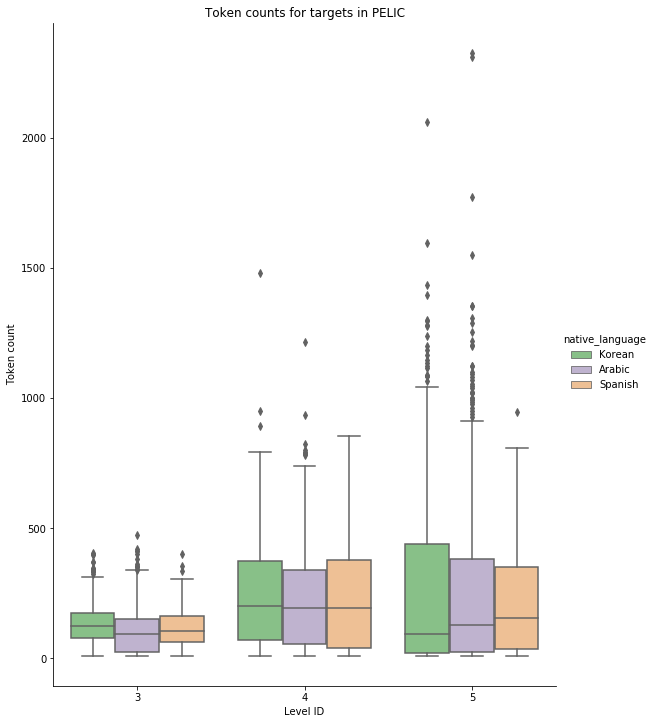

In [17]:
fig1 = sns.catplot(x='level_id', y='toks_re_len', kind='box', data=target_data, hue='native_language', 
            height=10, aspect=0.8, palette='Accent')
fig1.set_axis_labels(x_var="Level ID", y_var="Token count")
plt.title('Token counts for targets in PELIC')
fig1.savefig('../images/pelic_tokencts.png', bbox_inches='tight')

In [19]:
# Applying length filter to cap out so we have a comparable sample with CEPA essays
filters2 = (data.toks_re_len <= 400)
compare_target = data[filters & filters2]
compare_target.groupby('native_language')['level_id'].value_counts()

native_language  level_id
Arabic           4           1033
                 5            764
                 3            589
Korean           4            640
                 5            455
                 3            296
Spanish          4            123
                 5             75
                 3             64
Name: level_id, dtype: int64

Text(0.5, 1.0, 'Token counts for the smaller targets (PELIC)')

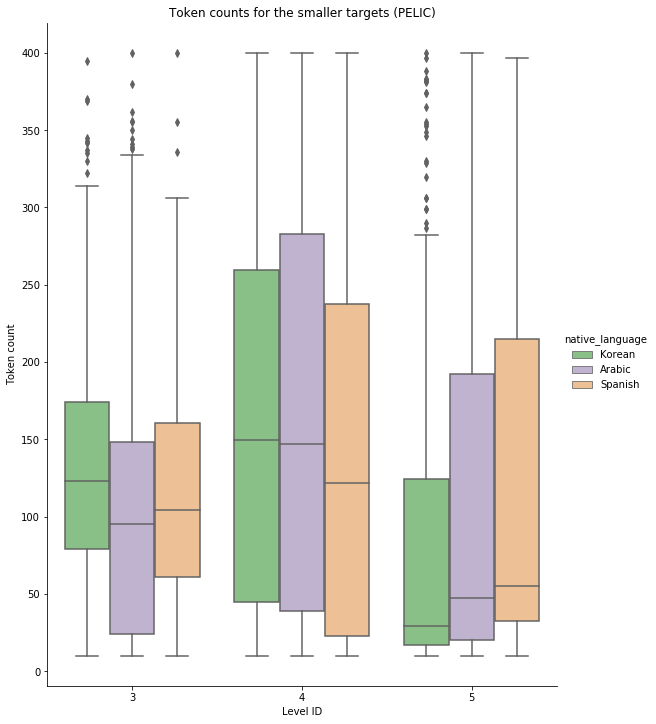

In [22]:
# Target samples, save as png
fig2 = sns.catplot(x='level_id', y='toks_re_len', kind='box', data=compare_target, hue='native_language', 
            height=10, aspect=0.8, palette='Accent')
fig2.set_axis_labels(x_var="Level ID", y_var="Token count")
plt.title('Token counts for the smaller targets (PELIC)')
fig2.savefig('../images/pelic_comparetargs_tokcts.png', bbox_inches='tight')

In [27]:
compare_target.to_csv("../private/pelic_targets.csv")
target_data.to_pickle("../private/pelic.pkl")

<a id='lemma'></a>
## Lemmas
Dr. Alan Juffs, also from the University of Pittsburgh and a member of the ELI Data Mining Group, already got the counts for the most frequent lemmas for each of the L1s I'm interested in, so we'll take a quick look at that. We'll need these to compare with BALC.

In [24]:
arabic_lemmas = pd.read_csv('/Users/elenacimino/Alan-Workspace/FREQ_Lists/Arabic_Level_3_FREQ2000_AAAL.csv', 
                           index_col=[0])
spanish_lemmas = pd.read_csv('/Users/elenacimino/Alan-Workspace/FREQ_Lists/SPAN_Level3_FREQ2000_Lema.csv',
                            index_col=[0])
korean_lemmas = pd.read_csv('/Users/elenacimino/Alan-Workspace/FREQ_Lists/Korean_Level3_FREQ2000_Lem.csv',
                            index_col=[0])

In [29]:
arabic_lemmas.head(10)
spanish_lemmas.head(6)
korean_lemmas.head(6)

,lemma,count
1,the,46073.0
2,be,41895.0
3,i,34769.0
4,to,34572.0
5,and,25170.0
6,in,23965.0
7,a,21613.0
8,of,17055.0
9,my,15495.0
10,have,14836.0


,lemma,count,per mil,totall words
NaN,NaN,NaN,50.372758,19852.0
1.0,i,54352.0,NaN,NaN
2.0,the,53043.0,NaN,NaN
3.0,be,51531.0,NaN,NaN
4.0,to,31332.0,NaN,NaN
5.0,a,29720.0,NaN,NaN


,lemma,count per m,per m x,Total Word count
NaN,NaN,NaN,13.37,"74,819"
1.0,be,50816.0,NaN,NaN
2.0,i,49667.0,NaN,NaN
3.0,a,33361.0,NaN,NaN
4.0,the,33160.0,NaN,NaN
5.0,to,30621.0,NaN,NaN


Already, we can see something interesting, and not totally unexpected. The most common lemma for Arabic L1 speakers is 'the', which follows a trend seen in English corpora like COCA, and may also fit within our hypothesis that Arabic L1 speakers overgeneralize the usage of the definite article 'the'.

Spanish L1 speakers' second most common lemma is 'the', which is also not super surprising. 

Korean students' two most common lemmas are actually the verb 'be' and the personal pronoun 'I', and then coming in third is the indefinite article 'a', which they actually use more than 'the'!

This actually fits in rather well with claims that:
- L1 speakers from [+art] langauges tend to acquire definite article 'the' first and use it as their default article
- L1 speakers from [-art] languages tend to acquire the indefinite articles 'a/an' before 'the' 

Interestingly, we see that while both Spanish and Korean L1 speakers have both 'the' and 'a' in their top five most common lemmas, Arabic L1 speakers only have 'the' in their top five most common lemmas. 'A' is actually seventh on their list! Could this be an artifact of avoidance?

<a id='conclusion'></a>
## Conclusion

In this notebook, I did a little poking around with my mini-datasets from PELIC. I was able to establish a cutoff for the analysis between BALC and PELIC (400 tokens) and looked around at the lemmas too. Now on prepping for data analysis and then the fun stuff: analysis itself!